# Earth Magnetic Field Viewer

The code presented here uses the International Geomagnetic Reference Field version 13 ([IGRF-13](https://www.ngdc.noaa.gov/IAGA/vmod/igrf.html)) to calculate the magnetic field elements to create a visualization of the Earth's magnetic field.

For this code, we use the igrf_utils.py file from the [python package](https://www.ngdc.noaa.gov/IAGA/vmod/pyIGRF.zip).


## Magnetic Field Elements at a Point

First we compute the magnetic field at a point (latitude, longitude and altitude). It is also necessary to know the date.

In [3]:
import numpy as np
import igrf_utils as iut
from scipy import interpolate

In [4]:
# Load in the file of coefficients
IGRF_FILE = r'./IGRF13.shc'
igrf = iut.load_shcfile(IGRF_FILE, None)    # Load shc-file and return coefficient arrays

In [3]:
date = 2023.1     # Date must be specified in decimal 
date = iut.check_float(date)
alt = 100       # In km, geodetic (shape of Earth using the WGS-84 ellipsoid)
alt = iut.check_float(alt)
lat = 4.444     # lat must be within -90 to +90 degrees
colat = 90-lat
lon = -74.895   #  long must be within -180 to +180 degrees 
itype = 1
alt, colat, sd, cd = iut.gg_to_geo(alt, colat)  # Compute geocentric colatitude and radius from geodetic colatitude and height

In [4]:
# Interpolate the geomagnetic coefficients to the desired date
f = interpolate.interp1d(igrf.time, igrf.coeffs, fill_value='extrapolate')
coeffs = f(date)

In [5]:
# Computes radial, colatitude and azimuthal field components from the magnetic potential field in terms of spherical harmonic coefficients.
Br, Bt, Bp = iut.synth_values(coeffs.T, alt, colat, lon, igrf.parameters['nmax'])

print("Magnetic field magnitude")
print(" Radial:", Br)
print(" Colatitude:", Bt)
print(" Azimuthal:", Bp)

Magnetic field magnitude
 Radial: -12982.24901212288
 Colatitude: -25488.566114584504
 Azimuthal: -3325.673356781644


In [6]:
 # Rearrange to X, Y, Z components 
X = -Bt; Y = Bp; Z = -Br
# Compute the four non-linear components 
dec, hoz, inc, eff = iut.xyz2dhif(X,Y,Z)    # Calculate D, H, I and F from (X, Y, Z)

In [7]:
print("Field components")
print(" Declination (D):", dec, "deg")
print(" Inclination (I):", inc, "deg")
print(" Horizontal intensity (H):", hoz, "nT")
print(" North component (X):", X, "nT")
print(" East component (Y):", Y, "nT")
print(" Vertical component (Z):", Z, "nT")
print(" Total intensity (F):", eff, "nT")

Field components
 Declination (D): -7.433790164624182 deg
 Inclination (I): 26.796297017276427 deg
 Horizontal intensity (H): 25704.612540428472 nT
 North component (X): 25488.566114584504 nT
 East component (Y): -3325.673356781644 nT
 Vertical component (Z): 12982.24901212288 nT
 Total intensity (F): 28796.977189738478 nT


## Basemap inclusion
To create a viewer, we need a map that shows the magnetic field at more than a single point. In this first attempt, we will use [Basemap](https://matplotlib.org/basemap/stable/).

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from gridaurora.worldgrid import latlonworldgrid

In [6]:
date = 2023.1     # Date must be specified in decimal 
date = iut.check_float(date)
alt = 420       # In km, geodetic (shape of Earth using the WGS-84 ellipsoid)
alt = iut.check_float(alt)
lat, lon = latlonworldgrid()
colat = 90-lat
itype = 1
alt, colat, sd, cd = iut.gg_to_geo(alt, colat)
f = interpolate.interp1d(igrf.time, igrf.coeffs, fill_value='extrapolate')
coeffs = f(date)

In [7]:
Br, Bt, Bp = iut.synth_values(coeffs.T, alt, colat, lon, igrf.parameters['nmax'])

e:\ProyectosFuturo\Earth Magnetic Field\igrf_utils.py:402: UserWarning: The geographic poles are included.
  warnings.warn('The geographic poles are included.')


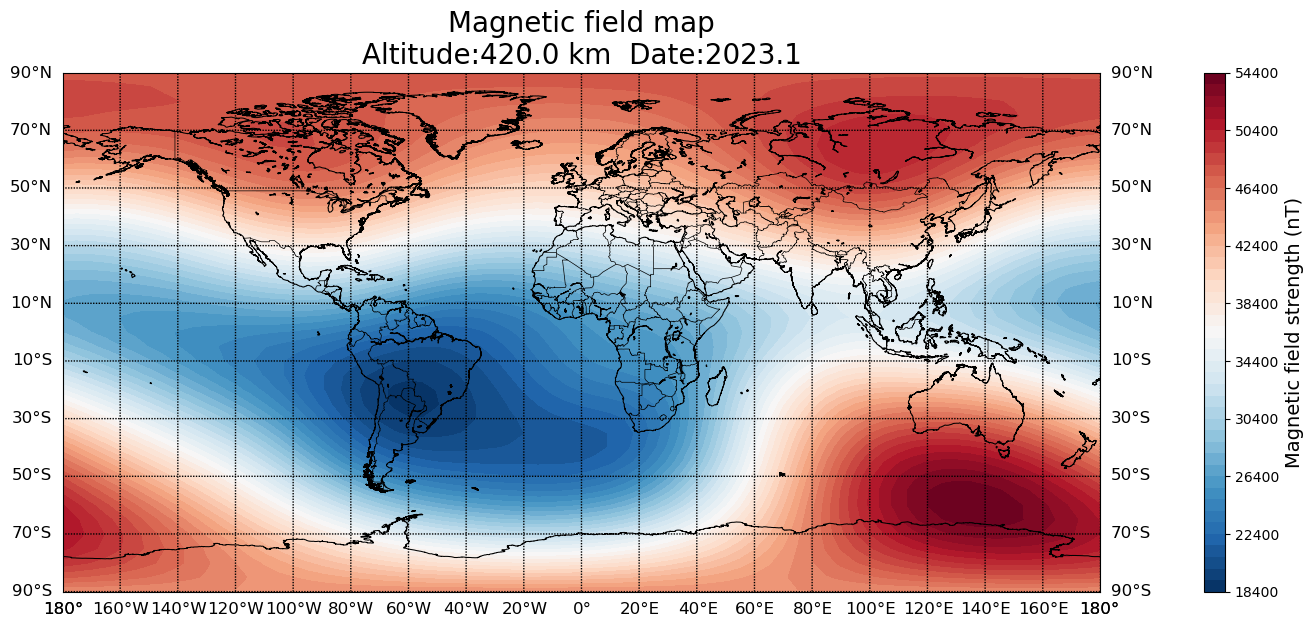

In [22]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Magnetic field map\n'+'Altitude:'+str(alt[0,0]-6356.752314245179)+' km  '+'Date:'+str(date),fontsize=20)

# Projection of the mapabase
m = Basemap(ax=ax, resolution='i', projection='cyl', area_thresh = 1000, llcrnrlat=-90,urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines(linewidth=0.75)
m.drawcountries(linewidth=0.5)
m.drawparallels( np.arange(-90, 91, 20), labels=[True,True,True,True], fontsize=12);
m.drawmeridians( np.arange(-180, 180, 20), labels=[True,True,False,True], fontsize=12);

# compute native x,y coordinates of grid.
x, y = m(lon, lat)
cs = m.contourf(x,y,np.sqrt(Br**2 + Bt**2 + Bp**2),55,cmap=plt.cm.RdBu_r)#alpha=0.75,
cbar = m.colorbar(cs,location='right',pad="10%",size="2%")
cbar.set_label('Magnetic field strength (nT)', fontsize=14)
plt.show()